<a href="https://colab.research.google.com/github/lrodrigocareaga/thesis/blob/master/MosquitoHybridModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [0]:
#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import keras,os,tarfile,sys,pickle,zipfile

#Keras libraries & packages
from keras import models,initializers,layers,optimizers
from keras import backend as K
from keras.utils import to_categorical,plot_model
from keras.models import Sequential,Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D,advanced_activations,Flatten,concatenate,Dropout,MaxPooling2D,Activation,GlobalAveragePooling2D,BatchNormalization,SeparableConv2D,SpatialDropout2D,LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

#Sci-kit libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold, ShuffleSplit
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, MultiLabelBinarizer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression


#Others
import time
import matplotlib.image as mpimg
import skimage
import argparse
import locale
import glob
import sklearn.model_selection
import cv2
import shapely.wkt
import shapely.affinity
import seaborn as sns
from skimage.io import imshow
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads

Using TensorFlow backend.


In [0]:
# Establish the home directory
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/mosquito')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://b7400e2e.ngrok.io


# Experiments

## Load Data Washington DC.


In [0]:
def loadData(fileXls):

  #Numerical and Categorical columns needed in the data
  cols = ['TOTAL','year','month','day','LATITUDE','LONGITUDE','TRAPID', 'GENUS']

  #Source file
  

  df_info = pd.read_excel(fileXls)

  #Erase blank rows
  df_info = df_info.dropna()

  #Add year and month
  df_info['year'] = df_info['TRAPCOLLECT'].dt.year.astype(int)
  df_info['month'] = df_info['TRAPCOLLECT'].dt.month.astype(int)
  df_info['day'] = df_info['TRAPCOLLECT'].dt.day.astype(int)

  #filter the dataset
  df = df_info[cols]
  df = df.dropna()

  return df

In [0]:
fileXls = '/content/drive/My Drive/mosquito/Mosquito_Trap.xlsx'
df = loadData(fileXls)

In [0]:
#Count of mosquitos trapped by ovitrap
def printInfo(df):
  traps = df["TRAPID"].value_counts().keys().tolist()
  countsTraps = df["TRAPID"].value_counts().tolist()
  print('TrapID of mosquitos captured by trap in Washington: ' + str(traps))
  print('Number of mosquitos captured by trap in Washington: ' + str(countsTraps))

  countMonthK = df["month"].value_counts().keys().tolist()
  countMonth = df["month"].value_counts().tolist()
  print('Number of mosquitos captured by Month in Manatee: ' + str(countMonthK))
  print('Number of mosquitos captured by Month in Manatee: ' + str(countMonth))

  countYearK = df["year"].value_counts().keys().tolist()
  countYear = df["year"].value_counts().tolist()
  print('Number of mosquitos captured by Year in Manatee: ' + str(countYearK))
  print('Number of mosquitos captured by Year in Manatee: ' + str(countYear))

  countGenusK = df["GENUS"].value_counts().keys().tolist()
  countGenus = df["GENUS"].value_counts().tolist()
  print('Number of mosquitos captured by Genus in Manatee: ' + str(countGenusK))
  print('Number of mosquitos captured by Genus in Manatee: ' + str(countGenus))

  return 

In [0]:
printInfo(df)

TrapID of mosquitos captured by trap in Washington: ['5A', '1B', '8A', '7A', '6A', '2B', '6B', '7B', '3B', '3A', '4A', '2A', '8B', '5B', '2C', '3D', '4B', '3C', '8C', '2D', '5C', '1A', '6C', '4C', '1C', '4D', '3E', '7C', '2E']
Number of mosquitos captured by trap in Washington: [183, 158, 140, 109, 105, 105, 104, 99, 98, 97, 83, 71, 69, 67, 61, 55, 51, 42, 40, 39, 35, 34, 31, 28, 28, 27, 25, 23, 16]
Number of mosquitos captured by Month in Manatee: [8, 7, 6, 9, 5, 10, 4]
Number of mosquitos captured by Month in Manatee: [526, 359, 350, 326, 215, 198, 49]
Number of mosquitos captured by Year in Manatee: [2016, 2017, 2018]
Number of mosquitos captured by Year in Manatee: [1022, 517, 484]
Number of mosquitos captured by Genus in Manatee: ['Culex', 'Aedes', 'Psorophora', 'Anopheles']
Number of mosquitos captured by Genus in Manatee: [1159, 850, 12, 2]


In [0]:
#DataFrame of number of mosquitos by trap
traps_df = pd.DataFrame({'Genus' : countGenusK,
                         'Total' : countGenus},
                         columns=['Genus','Total'])

traps_df.head()

,Genus,Total
0,Culex,1159
1,Aedes,850
2,Psorophora,12
3,Anopheles,2


In [0]:
#dataset of Washington Climate
df_climate = pd.read_excel('/content/drive/My Drive/mosquito/weatherData.xlsx')

In [0]:
df_climate['LATITUDE'] = df_climate['coordinates'].str.split(';').str[0].astype(float)
df_climate['LONGITUDE'] = df_climate['coordinates'].str.split(';').str[1].astype(float)
df_climate['date'] =  pd.to_datetime(df_climate['date'], format='%Y-%m-%d')
df_climate['year'] = df_climate['date'].dt.year.astype(int)
df_climate['month'] = df_climate['date'].dt.month.astype(int)
df_climate['day'] = df_climate['date'].dt.day.astype(int)

In [0]:
df_climate.head()

,coordinates,date,precipType,precipProbability,precipIntensity,precipIntensityMax,temperatureLow,temperatureHigh,temperatureMin,temperatureMax,humidity,windSpeed,cloudCover,LATITUDE,LONGITUDE,year,month,day
0,38.921453;-77.01448,2016-04-06,0,0.0,0.0000,0.0000,10.31,13.04,-2.39,13.04,0.52,1.50,0.15,38.921453,-77.014480,2016,4,6
1,38.914005;-77.057311,2016-04-06,0,0.0,0.0000,0.0000,10.52,13.32,-2.29,13.32,0.51,1.41,0.16,38.914005,-77.057311,2016,4,6
2,38.938009;-76.958136,2016-04-07,1,1.0,0.5652,5.2183,5.73,16.52,8.52,16.52,0.74,1.63,0.74,38.938009,-76.958136,2016,4,7
3,38.8731;-76.972813,2016-04-07,1,1.0,0.5762,5.3537,5.76,16.61,8.52,16.61,0.74,1.59,0.75,38.873100,-76.972813,2016,4,7
4,38.921453;-77.01448,2016-04-13,0,0.0,0.0000,0.0000,1.63,14.45,3.50,14.45,0.46,0.68,0.03,38.921453,-77.014480,2016,4,13


In [0]:
#Merge of climate and mosquitos dataset
result = pd.merge(df, df_climate, how='inner', on=['year','month','day','LATITUDE','LONGITUDE'])
result.head()

#Export dataset to csv
result.to_csv('result.csv',index=True)

result.TOTAL = result.TOTAL.astype(int)
del result['date']
del result['coordinates']

In [0]:
result.tail()

,TOTAL,year,month,day,LATITUDE,LONGITUDE,TRAPID,GENUS,precipType,precipProbability,precipIntensity,precipIntensityMax,temperatureLow,temperatureHigh,temperatureMin,temperatureMax,humidity,windSpeed,cloudCover
2018,11,2018,10,31,38.890913,-77.015562,2B,Culex,1,0.13,0.0001,0.0016,13.65,20.31,6.92,20.31,0.71,1.47,0.13
2019,2,2018,10,31,38.887771,-77.042323,2C,Culex,1,0.13,0.0002,0.0020,13.78,20.30,7.02,20.30,0.71,1.56,0.10
2020,3,2018,10,31,38.887646,-77.047678,2D,Culex,1,0.13,0.0002,0.0021,13.87,20.33,7.07,20.33,0.71,1.57,0.13
2021,4,2018,10,31,38.864642,-76.985929,8A,Culex,0,0.13,0.0000,0.0006,13.77,20.14,6.99,20.14,0.72,1.57,0.11
2022,2,2018,10,31,38.864642,-76.985929,8A,Aedes,0,0.13,0.0000,0.0006,13.77,20.14,6.99,20.14,0.72,1.57,0.11


In [0]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023 entries, 0 to 2022
Data columns (total 19 columns):
TOTAL                 2023 non-null int64
year                  2023 non-null int64
month                 2023 non-null int64
day                   2023 non-null int64
LATITUDE              2023 non-null float64
LONGITUDE             2023 non-null float64
TRAPID                2023 non-null object
GENUS                 2023 non-null object
precipType            2023 non-null int64
precipProbability     2023 non-null float64
precipIntensity       2023 non-null float64
precipIntensityMax    2023 non-null float64
temperatureLow        2023 non-null float64
temperatureHigh       2023 non-null float64
temperatureMin        2023 non-null float64
temperatureMax        2023 non-null float64
humidity              2023 non-null float64
windSpeed             2023 non-null float64
cloudCover            2023 non-null float64
dtypes: float64(12), int64(5), object(2)
memory usage: 316.1+ KB


## Visualization & data split Washington DC.

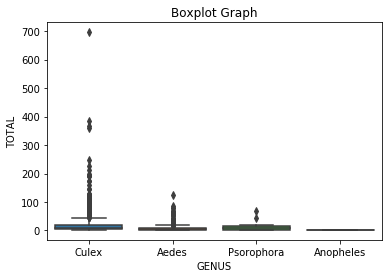

In [0]:
plt.plot()
sns.boxplot(x='GENUS',y='TOTAL',data=result)
plt.xlabel('GENUS')
plt.ylabel('TOTAL')
plt.title('Boxplot Graph')


plt.savefig('box_Overall_Year.eps', format='eps', dpi=900)
plt.show()

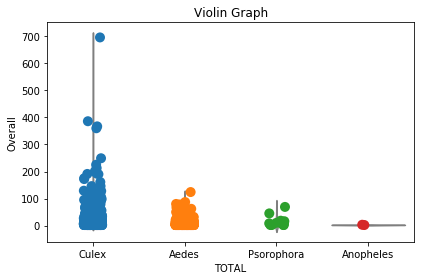

In [0]:
sns.violinplot(x='GENUS',y='TOTAL',data=result,inner=None,color='lightgray')
sns.stripplot(x='GENUS',y='TOTAL',data=result,size=10,jitter=True)
plt.xlabel('TOTAL')
plt.ylabel('Overall')
plt.title('Violin Graph')
plt.tight_layout()
plt.savefig('viol_Overall_Year.eps', format='eps', dpi=900)
plt.show()

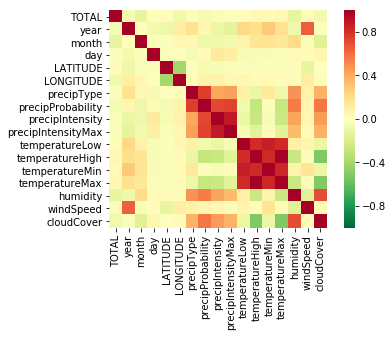

In [0]:
#Observe the correlation of the variables
corr = result.corr()
corr.style.background_gradient()

sns.heatmap(corr, cmap="RdYlGn_r", square= True, vmin=-1, vmax=1)
plt.savefig('corr.eps', format='eps', dpi=900)
# Display the heatmap
plt.show()

In [0]:
#split of dataset
(train, test) = train_test_split(result, test_size=0.3, random_state=33)

#continuous values of dataset
continuous = ['TOTAL','year',	'month','day',	'LATITUDE'	,'LONGITUDE',	'precipType','precipProbability','precipIntensity','precipIntensityMax','temperatureLow','temperatureHigh','temperatureMin','temperatureMax','humidity','windSpeed','cloudCover']

#Transforms features by scaling each feature to a given range.
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(train[continuous])
testContinuous = cs.transform(test[continuous])

zipBinarizer = LabelBinarizer().fit(result['GENUS'])
trainCategorical = zipBinarizer.transform(train['GENUS'])
testCategorical = zipBinarizer.transform(test['GENUS'])

trainX = np.hstack([trainCategorical, trainContinuous])
testX= np.hstack([testCategorical, testContinuous])

#Normalization of the values
maxMosquito = train["TOTAL"].max()
trainY = train["TOTAL"] / maxMosquito
testY = test["TOTAL"] / maxMosquito

## Load Data Manatee

In [0]:
#Numerical and Categorical columns needed in the data
cols = ['collection_date_end','GPS_lat','GPS_lon','species','sex','day','month','year','sample_count']

#Source file
file = '/content/drive/My Drive/mosquito/Manatee80.xlsx'

df_info = pd.read_excel(file)
df_info = df_info.iloc[:]
#Add year and month
df_info['year'] = df_info['collection_date_end'].dt.year
df_info['month'] = df_info['collection_date_end'].dt.month
df_info['day'] = df_info['collection_date_end'].dt.day

In [0]:
#filter the dataset
df = df_info[cols]
df['date'] = df['collection_date_end'].dt.strftime('%d-%m-%Y')
df = df.dropna()

df.day = df.day.astype(int)
df.month = df.month.astype(int)
df.year = df.year.astype(int)
df.sample_count = df.sample_count.astype(int)
df.sex = df.sex.astype(str)
df['GENUS'] = df['species'].str.split(' ').str[0].astype(str)
df['SPECIES'] = df['species'].str.split(' ').str[1].astype(str)
df = df.rename(columns={"GPS_lat": "LATITUDE", "GPS_lon": "LONGITUDE"})

del df['collection_date_end']
del df['species']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
df.head()

,LATITUDE,LONGITUDE,sex,day,month,year,sample_count,date,GENUS,SPECIES
0,27.516317,-82.537735,female,22,3,2012,2,22-03-2012,Culex,salinarius
1,27.516317,-82.537735,female,22,3,2012,3,22-03-2012,Culex,coronator
2,27.554018,-82.545481,female,22,3,2012,3,22-03-2012,Culex,nigripalpus
3,27.488870,-82.592140,female,22,3,2012,0,22-03-2012,BLANK,nan
4,27.439449,-82.548928,female,22,3,2012,1,22-03-2012,Culex,nigripalpus


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64369 entries, 0 to 64368
Data columns (total 10 columns):
LATITUDE        64369 non-null float64
LONGITUDE       64369 non-null float64
sex             64369 non-null object
day             64369 non-null int64
month           64369 non-null int64
year            64369 non-null int64
sample_count    64369 non-null int64
date            64369 non-null object
GENUS           64369 non-null object
SPECIES         64369 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 5.4+ MB


In [0]:
#Count of mosquitos trapped by ovitrap
countSexK = df["sex"].value_counts().keys().tolist()
countSex = df["sex"].value_counts().tolist()
print('TrapID of mosquitos captured by Sex in Manatee: ' + str(countSexK))
print('TrapID of mosquitos captured by Sex in Manatee: ' + str(countSex))

countMonthK = df["month"].value_counts().keys().tolist()
countMonth = df["month"].value_counts().tolist()
print('Number of mosquitos captured by Month in Manatee: ' + str(countMonthK))
print('Number of mosquitos captured by Month in Manatee: ' + str(countMonth))

countYearK = df["year"].value_counts().keys().tolist()
countYear = df["year"].value_counts().tolist()
print('Number of mosquitos captured by Year in Manatee: ' + str(countYearK))
print('Number of mosquitos captured by Year in Manatee: ' + str(countYear))

countGenusK = df["GENUS"].value_counts().keys().tolist()
countGenus = df["GENUS"].value_counts().tolist()
print('Number of mosquitos captured by Genus in Manatee: ' + str(countGenusK))
print('Number of mosquitos captured by Genus in Manatee: ' + str(countGenus))

countSpeciesK = df["SPECIES"].value_counts().keys().tolist()
countSpecies = df["SPECIES"].value_counts().tolist()
print('#Month of mosquitos captured by Species in Manatee: ' + str(countSpeciesK))
print('#Month of mosquitos captured by Species in Manatee: ' + str(countSpecies))

TrapID of mosquitos captured by Sex in Manatee: ['female']
TrapID of mosquitos captured by Sex in Manatee: [64369]
Number of mosquitos captured by Month in Manatee: [8, 7, 6, 9, 10, 5, 11, 4, 12, 3, 2, 1]
Number of mosquitos captured by Month in Manatee: [11109, 10999, 10887, 10429, 9977, 5500, 3564, 960, 636, 271, 26, 11]
Number of mosquitos captured by Year in Manatee: [2014, 2013, 2016, 2015, 2012, 2002]
Number of mosquitos captured by Year in Manatee: [14741, 13073, 12847, 12815, 10848, 45]
Number of mosquitos captured by Genus in Manatee: ['Culex', 'Aedes', 'Anopheles', 'Psorophora', 'Mansonia', 'Coquillettidia', 'Uranotaenia', 'Culiseta', 'Wyeomyia', 'BLANK', 'Culicidae', 'Culicinae', 'Orthopodomyia']
Number of mosquitos captured by Genus in Manatee: [22141, 12123, 11354, 9567, 5542, 1605, 1250, 520, 108, 78, 72, 6, 3]
#Month of mosquitos captured by Species in Manatee: ['nigripalpus', 'crucians', 'erraticus', 'columbiae', 'taeniorhynchus', 'titillans', 'infirmatus', 'quadrimacul

In [0]:
#dataset of Manatee Climate
df_climate = pd.read_excel('/content/drive/My Drive/mosquito/WeatherManateeFinal.xlsx')

In [0]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12198 entries, 0 to 12197
Data columns (total 13 columns):
coordinates           12198 non-null object
date                  12198 non-null object
precipType            12198 non-null int64
precipProbability     12198 non-null float64
precipIntensity       12198 non-null float64
precipIntensityMax    12198 non-null float64
temperatureLow        12198 non-null float64
temperatureHigh       12198 non-null float64
temperatureMin        12198 non-null float64
temperatureMax        12198 non-null float64
humidity              12198 non-null float64
windSpeed             12198 non-null float64
cloudCover            12198 non-null float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.2+ MB


In [0]:
df_climate['LATITUDE'] = df_climate['coordinates'].str.split(';').str[0].astype(float)
df_climate['LONGITUDE'] = df_climate['coordinates'].str.split(';').str[1].astype(float)

df_climate['date'] =  pd.to_datetime(df_climate['date'], format='%Y-%m-%d')
df_climate['year'] = df_climate['date'].dt.year.astype(int)
df_climate['month'] = df_climate['date'].dt.month.astype(int)
df_climate['day'] = df_climate['date'].dt.day.astype(int)


In [0]:
df_climate.head()

,coordinates,date,precipType,precipProbability,precipIntensity,precipIntensityMax,temperatureLow,temperatureHigh,temperatureMin,temperatureMax,humidity,windSpeed,cloudCover,LATITUDE,LONGITUDE,year,month,day
0,27.516317;-82.537735,2012-03-22,1,0.45,0.0141,0.1375,20.72,28.59,20.36,28.59,0.78,2.16,0.45,27.516317,-82.537735,2012,3,22
1,27.554018;-82.545481,2012-03-22,1,0.53,0.0162,0.2032,20.86,28.78,20.47,28.78,0.78,2.15,0.44,27.554018,-82.545481,2012,3,22
2,27.48887;-82.59214,2012-03-22,1,0.52,0.0090,0.1066,20.72,28.43,20.46,28.43,0.79,2.25,0.44,27.488870,-82.592140,2012,3,22
3,27.439449;-82.548928,2012-03-22,1,0.47,0.0156,0.2062,20.30,28.24,19.97,28.24,0.80,2.36,0.40,27.439449,-82.548928,2012,3,22
4,27.4266;-82.52471,2012-03-22,1,0.45,0.0156,0.2052,20.23,28.29,19.90,28.29,0.80,2.35,0.40,27.426600,-82.524710,2012,3,22


In [0]:
#Merge of climate and mosquitos dataset
result = pd.merge(df, df_climate, how='inner', on=['year','month','day','LATITUDE','LONGITUDE'])
result.head()

#Export dataset to csv
result.to_csv('result.csv',index=True)

del result['sex']
del result['date_x']
del result['coordinates']
result = result.rename(columns={"sample_count": "TOTAL", "date_y": "date"})

In [0]:
result.tail()
#result.info()

,LATITUDE,LONGITUDE,day,month,year,TOTAL,GENUS,SPECIES,date,precipType,precipProbability,precipIntensity,precipIntensityMax,temperatureLow,temperatureHigh,temperatureMin,temperatureMax,humidity,windSpeed,cloudCover
51495,27.426485,-82.376623,17,7,2012,422,Anopheles,crucians,2012-07-17,1,0.95,0.2161,1.8072,24.46,27.82,23.42,27.82,0.86,1.64,0.56
51496,27.590917,-82.548000,11,6,2015,426,Culex,nigripalpus,2015-06-11,1,0.90,0.0471,0.4515,22.66,31.12,23.38,31.12,0.78,1.45,0.28
51497,27.627967,-82.496833,11,8,2015,426,Psorophora,columbiae,2015-08-11,0,0.00,0.0000,0.0000,26.24,32.17,24.91,32.17,0.81,0.90,0.25
51498,27.627967,-82.496833,11,8,2015,426,Anopheles,crucians,2015-08-11,0,0.00,0.0000,0.0000,26.24,32.17,24.91,32.17,0.81,0.90,0.25
51499,27.442420,-82.435780,17,7,2012,428,Anopheles,crucians,2012-07-17,1,0.95,0.2394,1.3114,24.38,27.81,23.38,27.81,0.86,1.70,0.55


In [0]:
#take 5%, 10% or 20% of the outliers
#result = result.iloc[]

## Visualization & data split Manatee

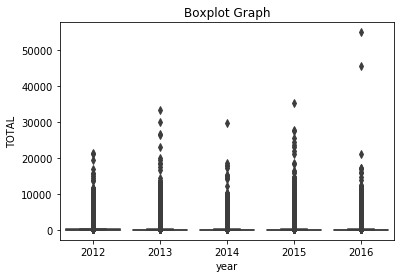

In [0]:
plt.plot()
sns.boxplot(x='year',y='TOTAL',data=result)
plt.xlabel('year')
plt.ylabel('TOTAL')
plt.title('Boxplot Graph')


plt.savefig('box_Overall_Year.eps', format='eps', dpi=900)
plt.show()

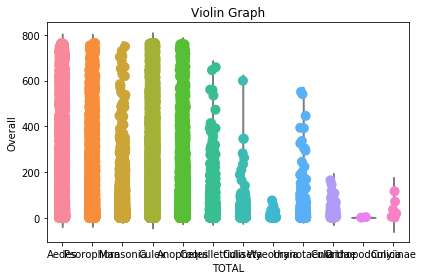

In [0]:
sns.violinplot(x='GENUS',y='TOTAL',data=result,inner=None,color='lightgray')
sns.stripplot(x='GENUS',y='TOTAL',data=result,size=10,jitter=True)
plt.xlabel('TOTAL')
plt.ylabel('Overall')
plt.title('Violin Graph')
plt.tight_layout()
plt.savefig('viol_Overall_Year.eps', format='eps', dpi=900)
plt.show()

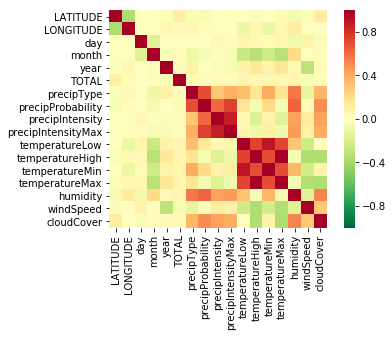

In [0]:
#Observe the correlation of the variables
corr = result.corr()
corr.style.background_gradient()

sns.heatmap(corr, cmap="RdYlGn_r", square= True, vmin=-1, vmax=1)
plt.savefig('corr.eps', format='eps', dpi=900)
# Display the heatmap
plt.show()

In [0]:
#split of dataset
(train, test) = train_test_split(result, test_size=0.2, random_state=33, shuffle=True)

#continuous values of dataset
continuous = ['TOTAL','precipType','precipProbability','precipIntensity','precipIntensityMax','temperatureLow','temperatureHigh','temperatureMin','temperatureMax','humidity','windSpeed','cloudCover']
#'year',	'month','day',	'LATITUDE'	,'LONGITUDE',	


#Transforms features by scaling each feature to a given range.
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(train[continuous])
testContinuous = cs.transform(test[continuous])

zipBinarizer = LabelBinarizer().fit(result['GENUS'])
trainCategorical = zipBinarizer.transform(train['GENUS'])
testCategorical = zipBinarizer.transform(test['GENUS'])

trainX = np.hstack([trainCategorical, trainContinuous])
testX= np.hstack([testCategorical, testContinuous])

#Normalization of the values
maxMosquito = train["TOTAL"].max()
trainY = train["TOTAL"] / maxMosquito
testY = test["TOTAL"] / maxMosquito

## Load Data Hernando

In [0]:
#Numerical and Categorical columns needed in the data
cols = ['collection_date_end','GPS_lat','GPS_lon','species','sex','day','month','year','sample_count']

#Source file
file = '/content/drive/My Drive/mosquito/Hernando.xlsx'

df_info = pd.read_excel(file)
df_info = df_info.iloc[:]
#Add year and month
df_info['year'] = df_info['collection_date_end'].dt.year
df_info['month'] = df_info['collection_date_end'].dt.month
df_info['day'] = df_info['collection_date_end'].dt.day

In [0]:
#filter the dataset
df = df_info[cols]
df['date'] = df['collection_date_end'].dt.strftime('%d-%m-%Y')
df = df.dropna()

df.day = df.day.astype(int)
df.month = df.month.astype(int)
df.year = df.year.astype(int)
df.sample_count = df.sample_count.astype(int)
df.sex = df.sex.astype(str)
df['GENUS'] = df['species'].str.split(' ').str[0].astype(str)
df['SPECIES'] = df['species'].str.split(' ').str[1].astype(str)
df = df.rename(columns={"GPS_lat": "LATITUDE", "GPS_lon": "LONGITUDE"})

del df['collection_date_end']
del df['species']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
df.head()

,LATITUDE,LONGITUDE,sex,day,month,year,sample_count,date,GENUS,SPECIES
0,27.516317,-82.537735,female,22,3,2012,2,22-03-2012,Culex,salinarius
1,27.516317,-82.537735,female,22,3,2012,3,22-03-2012,Culex,coronator
2,27.554018,-82.545481,female,22,3,2012,3,22-03-2012,Culex,nigripalpus
3,27.488870,-82.592140,female,22,3,2012,0,22-03-2012,BLANK,nan
4,27.439449,-82.548928,female,22,3,2012,1,22-03-2012,Culex,nigripalpus


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64369 entries, 0 to 64368
Data columns (total 10 columns):
LATITUDE        64369 non-null float64
LONGITUDE       64369 non-null float64
sex             64369 non-null object
day             64369 non-null int64
month           64369 non-null int64
year            64369 non-null int64
sample_count    64369 non-null int64
date            64369 non-null object
GENUS           64369 non-null object
SPECIES         64369 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 5.4+ MB


In [0]:
#Count of mosquitos trapped by ovitrap
countSexK = df["sex"].value_counts().keys().tolist()
countSex = df["sex"].value_counts().tolist()
print('TrapID of mosquitos captured by Sex in Manatee: ' + str(countSexK))
print('TrapID of mosquitos captured by Sex in Manatee: ' + str(countSex))

countMonthK = df["month"].value_counts().keys().tolist()
countMonth = df["month"].value_counts().tolist()
print('Number of mosquitos captured by Month in Manatee: ' + str(countMonthK))
print('Number of mosquitos captured by Month in Manatee: ' + str(countMonth))

countYearK = df["year"].value_counts().keys().tolist()
countYear = df["year"].value_counts().tolist()
print('Number of mosquitos captured by Year in Manatee: ' + str(countYearK))
print('Number of mosquitos captured by Year in Manatee: ' + str(countYear))

countGenusK = df["GENUS"].value_counts().keys().tolist()
countGenus = df["GENUS"].value_counts().tolist()
print('Number of mosquitos captured by Genus in Manatee: ' + str(countGenusK))
print('Number of mosquitos captured by Genus in Manatee: ' + str(countGenus))

countSpeciesK = df["SPECIES"].value_counts().keys().tolist()
countSpecies = df["SPECIES"].value_counts().tolist()
print('#Month of mosquitos captured by Species in Manatee: ' + str(countSpeciesK))
print('#Month of mosquitos captured by Species in Manatee: ' + str(countSpecies))

TrapID of mosquitos captured by Sex in Manatee: ['female']
TrapID of mosquitos captured by Sex in Manatee: [64369]
Number of mosquitos captured by Month in Manatee: [8, 7, 6, 9, 10, 5, 11, 4, 12, 3, 2, 1]
Number of mosquitos captured by Month in Manatee: [11109, 10999, 10887, 10429, 9977, 5500, 3564, 960, 636, 271, 26, 11]
Number of mosquitos captured by Year in Manatee: [2014, 2013, 2016, 2015, 2012, 2002]
Number of mosquitos captured by Year in Manatee: [14741, 13073, 12847, 12815, 10848, 45]
Number of mosquitos captured by Genus in Manatee: ['Culex', 'Aedes', 'Anopheles', 'Psorophora', 'Mansonia', 'Coquillettidia', 'Uranotaenia', 'Culiseta', 'Wyeomyia', 'BLANK', 'Culicidae', 'Culicinae', 'Orthopodomyia']
Number of mosquitos captured by Genus in Manatee: [22141, 12123, 11354, 9567, 5542, 1605, 1250, 520, 108, 78, 72, 6, 3]
#Month of mosquitos captured by Species in Manatee: ['nigripalpus', 'crucians', 'erraticus', 'columbiae', 'taeniorhynchus', 'titillans', 'infirmatus', 'quadrimacul

In [0]:
#dataset of Manatee Climate
df_climate = pd.read_excel('/content/drive/My Drive/mosquito/WeatherManateeFinal.xlsx')

In [0]:
df_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12198 entries, 0 to 12197
Data columns (total 13 columns):
coordinates           12198 non-null object
date                  12198 non-null object
precipType            12198 non-null int64
precipProbability     12198 non-null float64
precipIntensity       12198 non-null float64
precipIntensityMax    12198 non-null float64
temperatureLow        12198 non-null float64
temperatureHigh       12198 non-null float64
temperatureMin        12198 non-null float64
temperatureMax        12198 non-null float64
humidity              12198 non-null float64
windSpeed             12198 non-null float64
cloudCover            12198 non-null float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.2+ MB


In [0]:
df_climate['LATITUDE'] = df_climate['coordinates'].str.split(';').str[0].astype(float)
df_climate['LONGITUDE'] = df_climate['coordinates'].str.split(';').str[1].astype(float)

df_climate['date'] =  pd.to_datetime(df_climate['date'], format='%Y-%m-%d')
df_climate['year'] = df_climate['date'].dt.year.astype(int)
df_climate['month'] = df_climate['date'].dt.month.astype(int)
df_climate['day'] = df_climate['date'].dt.day.astype(int)


In [0]:
df_climate.head()

,coordinates,date,precipType,precipProbability,precipIntensity,precipIntensityMax,temperatureLow,temperatureHigh,temperatureMin,temperatureMax,humidity,windSpeed,cloudCover,LATITUDE,LONGITUDE,year,month,day
0,27.516317;-82.537735,2012-03-22,1,0.45,0.0141,0.1375,20.72,28.59,20.36,28.59,0.78,2.16,0.45,27.516317,-82.537735,2012,3,22
1,27.554018;-82.545481,2012-03-22,1,0.53,0.0162,0.2032,20.86,28.78,20.47,28.78,0.78,2.15,0.44,27.554018,-82.545481,2012,3,22
2,27.48887;-82.59214,2012-03-22,1,0.52,0.0090,0.1066,20.72,28.43,20.46,28.43,0.79,2.25,0.44,27.488870,-82.592140,2012,3,22
3,27.439449;-82.548928,2012-03-22,1,0.47,0.0156,0.2062,20.30,28.24,19.97,28.24,0.80,2.36,0.40,27.439449,-82.548928,2012,3,22
4,27.4266;-82.52471,2012-03-22,1,0.45,0.0156,0.2052,20.23,28.29,19.90,28.29,0.80,2.35,0.40,27.426600,-82.524710,2012,3,22


In [0]:
#Merge of climate and mosquitos dataset
result = pd.merge(df, df_climate, how='inner', on=['year','month','day','LATITUDE','LONGITUDE'])
result.head()

#Export dataset to csv
result.to_csv('result.csv',index=True)

del result['sex']
del result['date_x']
del result['coordinates']
result = result.rename(columns={"sample_count": "TOTAL", "date_y": "date"})

In [0]:
result.tail()
#result.info()

,LATITUDE,LONGITUDE,day,month,year,TOTAL,GENUS,SPECIES,date,precipType,precipProbability,precipIntensity,precipIntensityMax,temperatureLow,temperatureHigh,temperatureMin,temperatureMax,humidity,windSpeed,cloudCover
64327,27.578355,-82.483695,7,12,2016,538,Culex,nigripalpus,2016-12-07,0,0.0,0.0,0.0,15.27,24.35,16.36,24.35,0.84,1.27,0.17
64328,27.578355,-82.483695,7,12,2016,16,Mansonia,titillans,2016-12-07,0,0.0,0.0,0.0,15.27,24.35,16.36,24.35,0.84,1.27,0.17
64329,27.578355,-82.483695,7,12,2016,101,Anopheles,crucians,2016-12-07,0,0.0,0.0,0.0,15.27,24.35,16.36,24.35,0.84,1.27,0.17
64330,27.578355,-82.483695,7,12,2016,47,Culex,erraticus,2016-12-07,0,0.0,0.0,0.0,15.27,24.35,16.36,24.35,0.84,1.27,0.17
64331,27.578355,-82.483695,7,12,2016,8,Mansonia,dyari,2016-12-07,0,0.0,0.0,0.0,15.27,24.35,16.36,24.35,0.84,1.27,0.17


In [0]:
#take 5%, 10% or 20% of the outliers
#result = result.iloc[]

## Visualization & data split Hernando

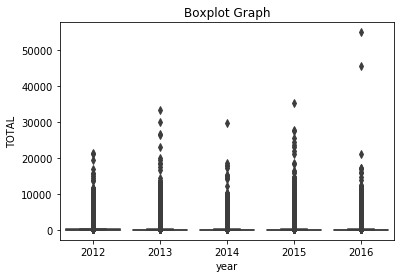

In [0]:
plt.plot()
sns.boxplot(x='year',y='TOTAL',data=result)
plt.xlabel('year')
plt.ylabel('TOTAL')
plt.title('Boxplot Graph')


plt.savefig('box_Overall_Year.eps', format='eps', dpi=900)
plt.show()

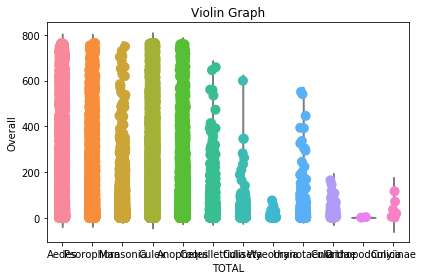

In [0]:
sns.violinplot(x='GENUS',y='TOTAL',data=result,inner=None,color='lightgray')
sns.stripplot(x='GENUS',y='TOTAL',data=result,size=10,jitter=True)
plt.xlabel('TOTAL')
plt.ylabel('Overall')
plt.title('Violin Graph')
plt.tight_layout()
plt.savefig('viol_Overall_Year.eps', format='eps', dpi=900)
plt.show()

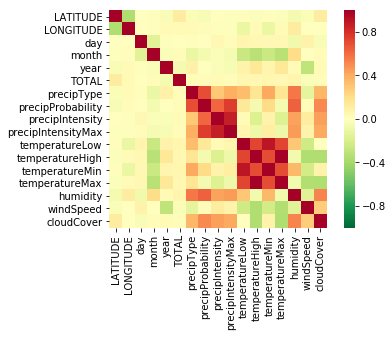

In [0]:
#Observe the correlation of the variables
corr = result.corr()
corr.style.background_gradient()

sns.heatmap(corr, cmap="RdYlGn_r", square= True, vmin=-1, vmax=1)
plt.savefig('corr.eps', format='eps', dpi=900)
# Display the heatmap
plt.show()

In [0]:
#split of dataset
(train, test) = train_test_split(result, test_size=0.2, random_state=33, shuffle=True)

#continuous values of dataset
continuous = ['TOTAL','precipType','precipProbability','precipIntensity','precipIntensityMax','temperatureLow','temperatureHigh','temperatureMin','temperatureMax','humidity','windSpeed','cloudCover']
#'year',	'month','day',	'LATITUDE'	,'LONGITUDE',	


#Transforms features by scaling each feature to a given range.
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(train[continuous])
testContinuous = cs.transform(test[continuous])

zipBinarizer = LabelBinarizer().fit(result['GENUS'])
trainCategorical = zipBinarizer.transform(train['GENUS'])
testCategorical = zipBinarizer.transform(test['GENUS'])

trainX = np.hstack([trainCategorical, trainContinuous])
testX= np.hstack([testCategorical, testContinuous])

#Normalization of the values
maxMosquito = train["TOTAL"].max()
trainY = train["TOTAL"] / maxMosquito
testY = test["TOTAL"] / maxMosquito

## SVM

In [0]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [0]:
from sklearn.svm import LinearSVR
from sklearn.datasets import make_regression

regrSVM = LinearSVR(random_state=0, tol=1e-5)
regrSVM.fit(trainX, trainY)  

print(regrSVM.coef_)

print(regrSVM.intercept_)






[ 1.00730507e-04  1.00715386e-04  1.00724403e-04  1.00724460e-04
  1.00724403e-04  1.00756013e-04  1.00723012e-04  1.00717092e-04
  9.86214846e-05  1.00720817e-04  1.00725156e-04  1.00678414e-04
  9.98692812e-01 -1.46931855e-08  2.81151667e-09 -2.81395606e-08
  2.03871655e-08  2.64924939e-08 -1.46556511e-06 -1.67722644e-08
  1.37537267e-06 -3.59314907e-09 -2.73378892e-08  1.50730767e-08]
[0.00120656]


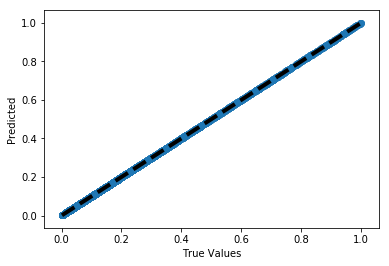

In [0]:
y_predSVM = regrSVM.predict(testX)
fig, ax = plt.subplots()
ax.scatter(testY, y_predSVM)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted')
plt.savefig('SVM.eps', format='eps', dpi=900)

plt.show()

## Linear Regression

In [0]:
linreg = LinearRegression()
linreg.fit(trainX, trainY)
y_predLinear = linreg.predict(testX)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(linreg.score(testX,testY)))
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(linreg.score(testX, testY))

Accuracy of linear regression classifier on test set: 1.00


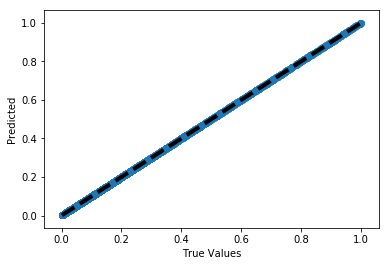

In [0]:
fig, ax = plt.subplots()
ax.scatter(testY, y_predLinear)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted')
plt.savefig('Linear.eps', format='eps', dpi=900)
plt.show()

## Logistic Regression

In [0]:
logreg = LogisticRegression()
logreg.fit(trainX, trainY)

y_predLog = logreg.predict(testX)
print('Accuracy of linear regression classifier on test set: {:.2f}'.format(logreg.score(testX,testY)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: ignored

In [0]:
fig, ax = plt.subplots()
ax.scatter(testY, y_predLog)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)

ax.set_xlabel('True Values')
ax.set_ylabel('Predicted')
plt.savefig('logistic.eps', format='eps', dpi=900)
plt.xlim(0,8000)
plt.ylim(0,20)
plt.show()

In [0]:
confusion_matrix = confusion_matrix(testY, y_predLog)
print(confusion_matrix)
print(classification_report(testY, y_predLog))

In [0]:
'''logit_roc_auc = roc_auc_score(testY, logreg.predict(testX))
fpr, tpr, thresholds = roc_curve(testY, logreg.predict_proba(testX)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()'''

## Dense Neural Network for Regression

In [0]:
model_checkpoint = ModelCheckpoint('RegMos.h5', verbose=1, save_best_only=True)

#model of dense neural network with 16, 8, 4 and 1 neurons in each layer respectively 
def create_mlp(dim, regress=False):
  model = Sequential()
  model.add(Dense(16, input_dim=dim, activation="relu"))
  model.add(Dense(8, activation="relu"))
  model.add(Dense(4, activation="relu"))
  
  if regress:
    model.add(Dense(1, activation="linear"))
  
  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  model.compile(optimizer=opt, loss="mean_absolute_percentage_error", metrics=['mae'])
  
  return model



In [0]:
k=5
num_val_samples = len(trainX) // k
num_epochs = 200
all_scores = []
model_history = [] 
start = time.clock()                 
for i in range(k):
  print('processing fold #', i)
  val_data = trainX[i*num_val_samples: (i+1) * num_val_samples]
  val_targets = trainY[i * num_val_samples: (i+1) * num_val_samples]
  
  partial_train_data = np.concatenate( [trainX[:i * num_val_samples], trainX[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate( [trainY[:i * num_val_samples], trainY[(i + 1) * num_val_samples:]], axis=0)
  model1 = create_mlp(trainX.shape[1], regress=True)
  history = model1.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs,callbacks=[model_checkpoint, TensorBoardColabCallback(tbc)], batch_size=16, verbose=1)
  model_history.append(history)
  val_mape,val_mae = model1.evaluate(testX, testY, verbose=1)
  all_scores.append(val_mape)
  
end = time.clock()
timeDense = end-start
#total time of training
print("Total Time: {} ".format(timeDense)) 

processing fold # 0






Train on 1133 samples, validate on 283 samples


Epoch 1/200
1133/1133 [==============================] - 1s 935us/step - loss: 1259.9775 - mean_absolute_error: 0.0934 - val_loss: 153.2349 - val_mean_absolute_error: 0.0179

Epoch 00001: val_loss improved from inf to 153.23495, saving model to RegMos.h5
Epoch 2/200
1133/1133 [==============================] - 0s 263us/step - loss: 136.5397 - mean_absolute_error: 0.0212 - val_loss: 102.0017 - val_mean_absolute_error: 0.0166

Epoch 00002: val_loss improved from 153.23495 to 102.00171, saving model to RegMos.h5
Epoch 3/200
1133/1133 [==============================] - 0s 267us/step - loss: 102.8080 - mean_absolute_error: 0.0196 - val_loss: 87.4159 - val_mean_absolute_error: 0.0165

Epoch 00003: val_loss improved from 102.00171 to 87.41590, saving model to RegMos.h5
Epoch 4/200
1133/1133 [==============================] - 0s 265us/step - loss: 85.7750 - mean_absolute_error: 0.0190 - val_loss: 82.1121 - val_mean_abso

In [0]:
all_scores
np.mean(all_scores)

30.110630211995108

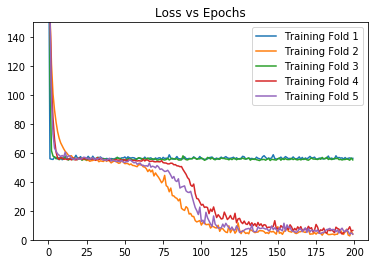

In [0]:
plt.title('Loss vs Epochs')
plt.plot(model_history[0].history['loss'], label='Training Fold 1')
plt.plot(model_history[1].history['loss'], label='Training Fold 2')
plt.plot(model_history[2].history['loss'], label='Training Fold 3')
plt.plot(model_history[3].history['loss'], label='Training Fold 4')
plt.plot(model_history[4].history['loss'], label='Training Fold 5')
plt.legend()
plt.ylim(0,150)
plt.show()

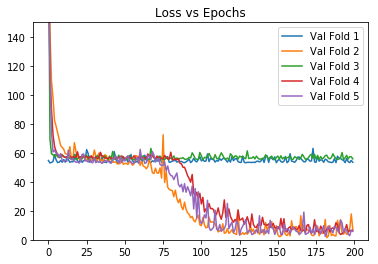

In [0]:
plt.title('Loss vs Epochs')
plt.plot(model_history[0].history['val_loss'], label='Val Fold 1')
plt.plot(model_history[1].history['val_loss'], label='Val Fold 2')
plt.plot(model_history[2].history['val_loss'], label='Val Fold 3')
plt.plot(model_history[3].history['val_loss'], label='Val Fold 4')
plt.plot(model_history[4].history['val_loss'], label='Val Fold 5')
plt.legend()
plt.ylim(0,150)
plt.show()

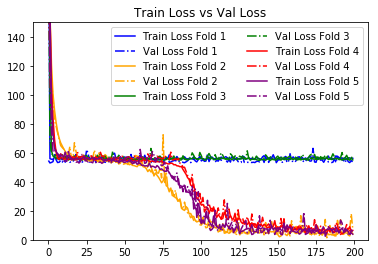

In [0]:
plt.title('Train Loss vs Val Loss')
plt.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='blue')
plt.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='blue', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='orange', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='orange', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='red', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='red', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Train Loss Fold 5', color='purple', )
plt.plot(model_history[4].history['val_loss'], label='Val Loss Fold 5', color='purple', linestyle = "dashdot")
plt.legend(ncol=2)
plt.ylim(0,150)
plt.show()

In [0]:
#save model2 plot as png and display summary
plot_model(model1, show_shapes = 1, to_file='DenseModel.png')
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 16)                352       
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


In [0]:
#evaluation of the model with test data 
test_lossDense = model1.evaluate(testX, testY)

preds = model1.predict(testX)

607/607 [==============================] - 0s 58us/step


In [0]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [0]:
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [0]:
print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. mosquito traped: 14.563519525457242, std mosquito trapped: 30.36583394682834
[INFO] mean: 6.58%, std: 11.64%


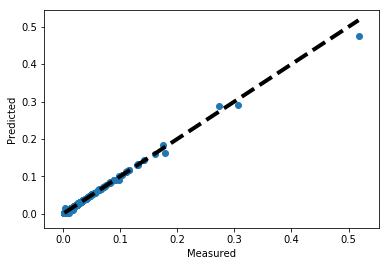

In [0]:
fig, ax = plt.subplots()
ax.scatter(testY, preds)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [0]:
for layer in model1.layers:
    weights = layer.get_weights()

In [0]:
weights

[array([[ 0.13013366],
        [-0.57156134],
        [-0.9466314 ],
        [-0.3740898 ]], dtype=float32), array([0.00331615], dtype=float32)]

In [0]:
model = load_model('RegMos.h5')

Loaded model from disk
mean_absolute_percentage_error: 4.36%


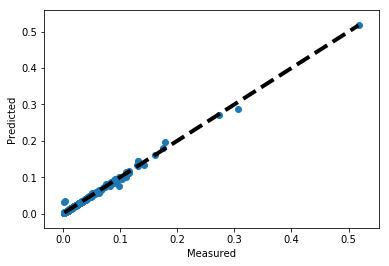

In [0]:
model.load_weights("RegMos.h5")
print("Loaded model from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mape'])
score = model.evaluate(testX, testY, verbose=0)
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]))
preds = model.predict(testX)

fig, ax = plt.subplots()
ax.scatter(testY, preds)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## CNN with Images

In [0]:
start = time.clock() 

inputPath = '/content/drive/My Drive/mosquito/imagesSat'
images = []

for i in result['TRAPID']:
  basePath = os.path.sep.join([inputPath, "{}_*".format(i)])
  imagePaths = sorted(list(glob.glob(basePath)))
  inputImages = []
  outputImage = np.zeros((256, 256, 3), dtype="uint8")
  
  for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (128, 128))
    inputImages.append(image)

  outputImage[0:128, 0:128] = inputImages[0]
  outputImage[128:256, 0:128] = inputImages[1]
  outputImage[0:128, 128:256] = inputImages[2]
  outputImage[128:256, 128:256] = inputImages[3]
  images.append(outputImage)
  
end = time.clock()
timeImages = end-start

print("Total Time: {} ".format(timeImages)) 

Total Time: 501.93874600000004 


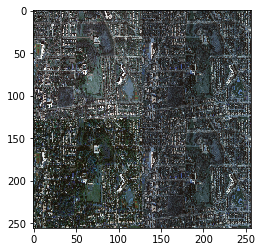

In [0]:
plt.imshow(images[2])

In [0]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [0]:
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/mosquito/mosquitoImages',  # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='sparse')

Found 87 images belonging to 29 classes.


In [0]:
images = np.array(images)
images = images/255.0

In [0]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(result, images, test_size=0.3, random_state=33)

In [0]:
maxMosquito = trainAttrX["TOTAL"].max()
trainY = trainAttrX["TOTAL"] / maxMosquito
testY = testAttrX["TOTAL"] / maxMosquito

In [0]:
model_checkpoint2 = ModelCheckpoint('RegMos2.h5', verbose=1, save_best_only=True)
def create_cnn(width, height, depth, filters=(16,32,64),regress=False):
  
  inputShape = (height, width, depth)
  chanDim = -1
  
  inputs = Input(shape=inputShape)
  
  for (i,f) in enumerate(filters):
    if i == 0:
      x = inputs
      
    x = Conv2D(f, (3,3), padding='same', kernel_regularizer='l2')(x)
    x = Activation ('relu')(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
  x = Flatten()(x)
  x = Dense(16)(x)
  x = Activation('relu')(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Dropout(0.4)(x)
  
  x = Dense(4)(x)
  x = Activation('relu')(x)
  
  if regress:
    x = Dense(1,activation='linear')(x)
    
  model = Model(inputs,x)
  opt = Adam(lr=1e-3, decay=1e-3 / 200) 
  model.compile(optimizer=opt, loss="mean_absolute_percentage_error", metrics=['mae'])
  
  return model

In [0]:
k=5
num_val_samples = len(trainAttrX) // k
num_epochs = 50
all_scores2 = []
model_history2 = [] 
start = time.clock()                 
for i in range(k):
  print('processing fold #', i)
  val_data = trainImagesX[i*num_val_samples: (i+1) * num_val_samples]
  val_targets = trainY[i * num_val_samples: (i+1) * num_val_samples]
  
  partial_train_data = np.concatenate( [trainImagesX[:i * num_val_samples], trainImagesX[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate( [trainY[:i * num_val_samples], trainY[(i + 1) * num_val_samples:]], axis=0)
  model2 = create_cnn(256, 256, 3, regress=True)
  history2 = model2.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs,callbacks=[model_checkpoint2, TensorBoardColabCallback(tbc)], batch_size=16, verbose=1)
  model_history2.append(history2)
  val_mape,val_mae = model2.evaluate(testImagesX, testY, verbose=1)
  all_scores2.append(val_mape)
  
end = time.clock()
timeDense = end-start
#total time of training
print("Total Time: {} ".format(timeDense)) 

processing fold # 0


W0805 14:42:36.740972 140331944114048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0805 14:42:36.820098 140331944114048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 14:42:37.174492 140331944114048 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 1133 samples, validate on 283 samples
Epoch 1/50
1133/1133 [==============================] - 9s 8ms/step - loss: 8227.4436 - mean_absolute_error: 0.6105 - val_loss: 7174.1905 - val_mean_absolute_error: 0.5818

Epoch 00001: val_loss improved from inf to 7174.19054, saving model to RegMos2.h5
Epoch 2/50
1133/1133 [==============================] - 6s 5ms/step - loss: 3449.2932 - mean_absolute_error: 0.2726 - val_loss: 4401.4366 - val_mean_absolute_error: 0.3118

Epoch 00002: val_loss improved from 7174.19054 to 4401.43664, saving model to RegMos2.h5
Epoch 3/50
1133/1133 [==============================] - 6s 5ms/step - loss: 1599.5279 - mean_absolute_error: 0.1226 - val_loss: 955.6409 - val_mean_absolute_error: 0.0644

Epoch 00003: val_loss improved from 4401.43664 to 955.64086, saving model to RegMos2.h5
Epoch 4/50
1133/1133 [==============================] - 6s 5ms/step - loss: 908.4872 - mean_absolute_error: 0.0770 - val_loss: 299.3860 - val_mean_absolute_error: 0.0324

Epoch

In [0]:
#save model2 plot as png and display summary
plot_model(model2, show_shapes = 1, to_file='CNNModel.png')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
activation_21 (Activation)   (None, 256, 256, 16)      0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 32)      0         
__________

In [0]:
preds = model2.predict(testImagesX)

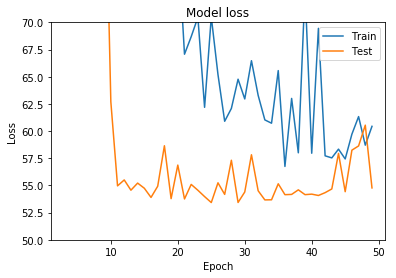

In [0]:
# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1,51)
plt.ylim(50,70)
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

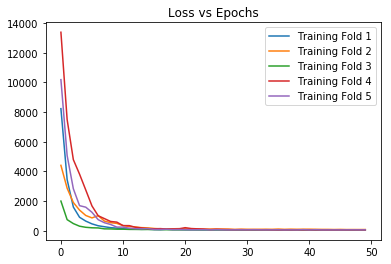

In [0]:
plt.title('Loss vs Epochs')
plt.plot(model_history2[0].history['loss'], label='Training Fold 1')
plt.plot(model_history2[1].history['loss'], label='Training Fold 2')
plt.plot(model_history2[2].history['loss'], label='Training Fold 3')
plt.plot(model_history2[3].history['loss'], label='Training Fold 4')
plt.plot(model_history2[4].history['loss'], label='Training Fold 5')
plt.legend()
plt.show()

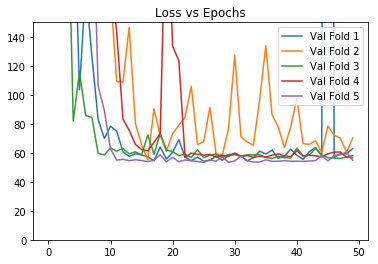

In [0]:
plt.title('Loss vs Epochs')
plt.plot(model_history2[0].history['val_loss'], label='Val Fold 1')
plt.plot(model_history2[1].history['val_loss'], label='Val Fold 2')
plt.plot(model_history2[2].history['val_loss'], label='Val Fold 3')
plt.plot(model_history2[3].history['val_loss'], label='Val Fold 4')
plt.plot(model_history2[4].history['val_loss'], label='Val Fold 5')
plt.legend()
plt.ylim(0,150)
plt.show()

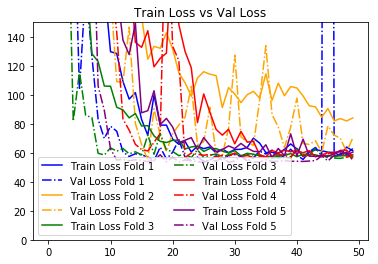

In [0]:
plt.title('Train Loss vs Val Loss')
plt.plot(model_history2[0].history['loss'], label='Train Loss Fold 1', color='blue')
plt.plot(model_history2[0].history['val_loss'], label='Val Loss Fold 1', color='blue', linestyle = "dashdot")
plt.plot(model_history2[1].history['loss'], label='Train Loss Fold 2', color='orange', )
plt.plot(model_history2[1].history['val_loss'], label='Val Loss Fold 2', color='orange', linestyle = "dashdot")
plt.plot(model_history2[2].history['loss'], label='Train Loss Fold 3', color='green', )
plt.plot(model_history2[2].history['val_loss'], label='Val Loss Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history2[3].history['loss'], label='Train Loss Fold 4', color='red', )
plt.plot(model_history2[3].history['val_loss'], label='Val Loss Fold 4', color='red', linestyle = "dashdot")
plt.plot(model_history2[4].history['loss'], label='Train Loss Fold 5', color='purple', )
plt.plot(model_history2[4].history['val_loss'], label='Val Loss Fold 5', color='purple', linestyle = "dashdot")
plt.legend(ncol=2)
plt.ylim(0,150)
plt.show()

In [0]:
#evaluation of the model with test data 

preds2 = model2.predict(testImagesX)

In [0]:
diff2 = preds2.flatten() - testY
percentDiff2 = (diff2 / testY) * 100
absPercentDiff2 = np.abs(percentDiff2)

In [0]:
mean2 = np.mean(absPercentDiff2)
std2 = np.std(absPercentDiff2)

In [0]:
print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean2, std2))

[INFO] avg. mosquito traped: 14.563519525457242, std mosquito trapped: 30.36583394682834
[INFO] mean: 53.85%, std: 27.94%


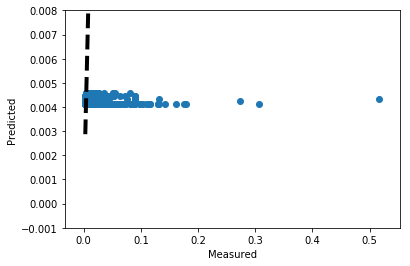

In [0]:
fig, ax = plt.subplots()
ax.scatter(testY, preds2)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.ylim(-0.001,0.008)
plt.show()

In [0]:
for layer in model22.layers:
    weights = layer.get_weights()

In [0]:
weights

[array([[ 0.13013366],
        [-0.57156134],
        [-0.9466314 ],
        [-0.3740898 ]], dtype=float32), array([0.00331615], dtype=float32)]

In [0]:
model = load_model('RegMos.h5')

Loaded model from disk
mean_absolute_percentage_error: 4.36%


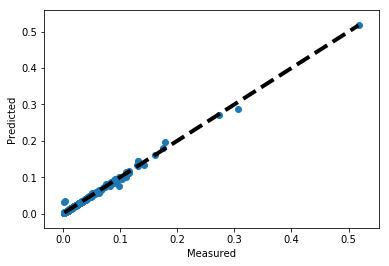

In [0]:
model.load_weights("RegMos.h5")
print("Loaded model from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mape'])
score = model.evaluate(testX, testY, verbose=0)
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]))
preds = model.predict(testX)

fig, ax = plt.subplots()
ax.scatter(testY, preds)
ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Transfer Learning ResNet

In [0]:
'''modelTransf2=ResNet50(weights=None,
                      include_top=True,
                      classes=1,
                      input_shape=(64,64,3))

modelTransf2 = Sequential()


modelTransf2.add(base_modelRes)
modelTransf2.add(Flatten())
modelTransf2.add(BatchNormalization())
modelTransf2.add(Dense(128, activation='linear'))
modelTransf2.add(layers.LeakyReLU(alpha=0.1))           
modelTransf2.add(Dropout(0.3))
modelTransf2.add(Dense(21, activation='softmax'))

modelTransf2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])'''

In [0]:
'''#ResNet50 Vainilla
start = time.clock() 
historyRes = modelTransf2.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),epochs=200, batch_size=8)

end = time.clock()
timeRes = end-start

print("Total Time: {} ".format(timeRes)) '''

In [0]:
'''train_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True)

train_generator.fit(trainImagesX)
#ResNet with Data Augmentantion
historyResDA = modelTransf2.fit_generator(
        train_generator.flow(trainImagesX, trainY,epochs=200, batch_size=8),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(testImagesX, testY), batch_size=32),
        validation_steps=128,
        verbose=2
    )'''

## Combine the models

In [0]:
model_checkpoint3 = ModelCheckpoint('RegMos3.h5', verbose=1, save_best_only=True)
def hybridModel():
  mlp = create_mlp(trainX.shape[1], regress=False)
  cnn = create_cnn(256, 256, 3, regress=False)

  combinedInput = concatenate([mlp.output, cnn.output])

  x = Dense(8, activation="relu")(combinedInput)
  x = Dense(4, activation="relu")(x)
  x = Dense(1, activation="linear")(x)

  modelF = Model(inputs=[mlp.input, cnn.input], outputs=x)

  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  modelF.compile(optimizer=opt, loss="mean_absolute_percentage_error", metrics=['mae'])
  
  return modelF

checar hasta aqui llegue el sabado 20 de julio

In [0]:
k=5
xtrain = [trainX, trainImagesX]
num_val_samples = [(len(xtrain)) // k,17]
num_epochs = 50
all_scores3 = []
model_history3 = [] 
start = time.clock()                 
for i in range(k):
  print('processing fold #', i)
  val_data = xtrain[i*num_val_samples: (i+1) * num_val_samples]
  val_targets = trainY[i * num_val_samples: (i+1) * num_val_samples]
  
  partial_train_data = np.concatenate([xtrain[:i * num_val_samples], xtrain[(i + 1) * num_val_samples:]], axis=1)
  partial_train_targets = np.concatenate( [trainY[:i * num_val_samples], trainY[(i + 1) * num_val_samples:]], axis=0)
  modelF = hybridModel()
  history3 = modelF.fit(partial_train_data, partial_train_targets,validation_data=(val_data, val_targets),epochs=num_epochs,callbacks=[model_checkpoint3, TensorBoardColabCallback(tbc)], batch_size=16, verbose=1)
  model_history3.append(history3)
  val_mape,val_mae = modelF.evaluate([testX, testImagesX], testY, verbose=1)
  all_scores2.append(val_mape)
  
end = time.clock()
timeDense = end-start
#total time of training
print("Total Time: {} ".format(timeDense)) 

processing fold # 0


TypeError: ignored

In [0]:
modelF = hybridModel()
#save model plot as png and display summary
plot_model(modelF, show_shapes = 1, to_file='HybModel.png')
modelF.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 16) 0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 256, 256, 16) 64          activation_36[0][0]              
__________________________________________________________________________________________________
max_poolin

In [0]:

history3 = modelF.fit([trainX, trainImagesX], trainY, validation_data=([testX, testImagesX], testY),epochs=200,callbacks=[model_checkpoint3, TensorBoardColabCallback(tbc)], batch_size=16)

preds = modelF.predict([testX, testImagesX])

Train on 1416 samples, validate on 607 samples
Epoch 1/200
1416/1416 [==============================] - 8s 6ms/step - loss: 626.0858 - mean_absolute_error: 0.0541 - val_loss: 77.4509 - val_mean_absolute_error: 0.0164

Epoch 00001: val_loss improved from inf to 77.45092, saving model to RegMos3.h5
Epoch 2/200
1416/1416 [==============================] - 6s 4ms/step - loss: 82.5291 - mean_absolute_error: 0.0187 - val_loss: 87.8507 - val_mean_absolute_error: 0.0183

Epoch 00002: val_loss did not improve from 77.45092
Epoch 3/200
1416/1416 [==============================] - 6s 4ms/step - loss: 60.2530 - mean_absolute_error: 0.0178 - val_loss: 61.5160 - val_mean_absolute_error: 0.0163

Epoch 00003: val_loss improved from 77.45092 to 61.51603, saving model to RegMos3.h5
Epoch 4/200
1416/1416 [==============================] - 6s 4ms/step - loss: 58.2941 - mean_absolute_error: 0.0177 - val_loss: 55.8691 - val_mean_absolute_error: 0.0161

Epoch 00004: val_loss improved from 61.51603 to 55.8690

In [0]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
 

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 

print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))




[INFO] avg. mosquito traped: 14.563519525457242, std mosquito trapped: 30.36583394682834
[INFO] mean: 53.62%, std: 28.40%


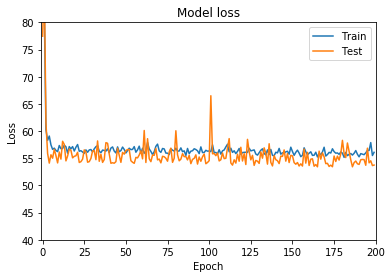

In [0]:
# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlim(-1,200)
plt.ylim(40,80)
plt.show()

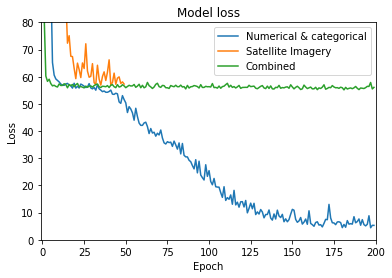

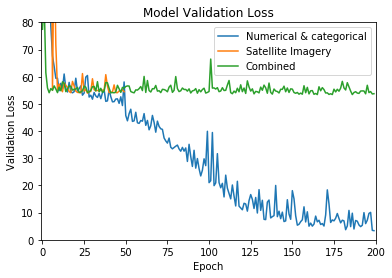

In [0]:
plt.plot(history.history['loss'], label='Numerical & categorical')
plt.plot(history2.history['loss'], label='Satellite Imagery')
plt.plot(history3.history['loss'], label='Combined')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.xlim(-1,200)
plt.ylim(0,80)
plt.show()


plt.plot(history.history['val_loss'], label='Numerical & categorical')
plt.plot(history2.history['val_loss'], label='Satellite Imagery')
plt.plot(history3.history['val_loss'], label='Combined')

plt.title('Model Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend( loc='upper right')
plt.xlim(-1,200)
plt.ylim(0,80)
plt.show()



## Sources

Source: 

[1] Cahill, Trey. (2019). Esri Story Maps: Fight the Bite, Protecting Washington, D.C. from Mosquito Borne Disease. 

[2] Giraldo-Calderón GI, Emrich SJ, MacCallum RM, Maslen G, Dialynas E, Topalis P, Ho N, Gesing S, VectorBase Consortium, Madey G, Collins FH, Lawson D. 2015. VectorBase: an updated bioinformatics resource for invertebrate vectors and other organisms related with human diseases. Nucleic Acids Research 43(Database issue):D707-13.

[3] Ehelepola, N. D. B., et al. "A study of the correlation between dengue and weather in Kandy City, Sri Lanka (2003-2012) and lessons learned." Infectious diseases of poverty 4.1 (2015): 42.

H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

https://zoom.earth

In [0]:
'https://wtop.com/health-fitness/2016/06/trap-lab-dc-protects-residents-mosquito-borne-diseases/slide/1/'